# Previsione della Qualità dell'Aria - **Allenamento con Dati Augmentati e Valutazione dei Modelli Cina**

**Progetto di Data Intensive**  
**Autore:** Martin Tomassi, Jacopo Vasi  
**Email:** martin.tomassi@studio.unibo.it , jacopo.vasi@studio.unibo.it  
**Corso:** Data Intensive, Università di Bologna  
**Data:** Aprile 2025

## Caricamento dei Datasets ed Import Librerie



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

try:
    import google.colab
    running_in_colab = True
except ImportError:
    running_in_colab = False

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    max_error
)
from sklearn.model_selection import (
    TimeSeriesSplit,
    RandomizedSearchCV,
    GridSearchCV,
    ParameterSampler
)
from sklearn.linear_model import (
    LinearRegression,
    Lasso,
    Ridge,
    ElasticNet
)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Subset

%pip install xgboost
from xgboost import XGBRegressor

N_JOBS = -1
RANDOM_STATE = 42

In [2]:
if running_in_colab:
    df = pd.read_csv('https://raw.githubusercontent.com/vMxster/Data_Project/main/Datasets/aug_cina_dataset.csv',
                 sep=',',
                 quotechar='"',
                 dtype=None,
                 parse_dates=True,
                 low_memory=False)
else:
    df = pd.read_csv('aug_cina_dataset.csv',
                     sep=',',
                     quotechar='"',
                     dtype=None,
                     parse_dates=True,
                     low_memory=False)


obj_cols = df.select_dtypes(include="object").columns
for col in obj_cols:
    df[col] = df[col].astype("string")
df = df[(df['year'] >= 2020) & (df['year'] <= 2022)]
df = df.reset_index(drop=True)
df.head()

,year,month,dayofmonth,state,PM2.5,CO,O3,dayofweek,quarter,weekofyear,...,o3_lag_1Y,pm_lag_2Y,co_lag_2Y,o3_lag_2Y,pm_lag_1M,co_lag_1M,o3_lag_1M,pm_lag_1W,co_lag_1W,o3_lag_1W
0,2020,1,1,Madhya Pradesh,90.081692,0.913343,28.474670,2,1,1,...,63.127333,205.530417,1.355000,82.097708,80.834386,0.833265,52.997402,95.927965,0.837701,33.082604
1,2020,1,1,Telangana,40.587069,0.637917,28.698722,2,1,1,...,31.786597,57.492500,0.978417,39.430486,44.600486,0.610000,21.900069,71.744167,0.735000,34.434514
2,2020,1,1,Uttar Pradesh,297.640091,2.383276,20.390113,2,1,1,...,31.685147,256.078693,2.350186,21.805840,131.564711,1.380966,36.720730,166.373550,1.235140,14.403787
3,2020,1,1,Tamil Nadu,28.776333,0.563250,26.441354,2,1,1,...,56.341250,50.512778,0.000000,28.469167,21.982153,0.457937,22.081910,49.426875,0.819271,30.534444
4,2020,1,1,Bihar,250.718403,2.375313,23.546944,2,1,1,...,47.750833,248.338542,1.253194,25.368750,154.494167,1.688611,34.127569,164.204097,1.309479,23.852819


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25658 entries, 0 to 25657
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        25658 non-null  int64  
 1   month       25658 non-null  int64  
 2   dayofmonth  25658 non-null  int64  
 3   state       25658 non-null  string 
 4   PM2.5       25658 non-null  float64
 5   CO          25658 non-null  float64
 6   O3          25658 non-null  float64
 7   dayofweek   25658 non-null  int64  
 8   quarter     25658 non-null  int64  
 9   weekofyear  25658 non-null  int64  
 10  dayofyear   25658 non-null  int64  
 11  date        25658 non-null  string 
 12  pm_lag_1Y   21511 non-null  float64
 13  co_lag_1Y   21511 non-null  float64
 14  o3_lag_1Y   21511 non-null  float64
 15  pm_lag_2Y   19742 non-null  float64
 16  co_lag_2Y   19742 non-null  float64
 17  o3_lag_2Y   19742 non-null  float64
 18  pm_lag_1M   25328 non-null  float64
 19  co_lag_1M   25328 non-nul

# Addestramento modelli
A seguito dell'esplorazione e dell'omogeneizzazione dei due dataset, si può procedere all'addestramento dei modelli. I modelli verranno addestrati sulle seguenti feature indipendenti:
- `year`: anno della misurazione
- `month`: mese dell’anno
- `dayofmonth`: giorno del mese
- `dayofweek`: giorno della settimana
- `dayofyear`: giorno dell’anno
- `weekofyear`: settimana dell’anno
- `quarter`: trimestre dell’anno
- `state`: stato di misurazione
- `pm_lag_1W`: PM2.5 ritardato di 1 settimana
- `pm_lag_1M`: PM2.5 ritardato di 1 mese
- `pm_lag_1Y`: PM2.5 ritardato di 1 anno
- `pm_lag_2Y`: PM2.5 ritardato di 2 anni
- `co_lag_1W`: CO ritardato di 1 settimana
- `co_lag_1M`: CO ritardato di 1 mese
- `co_lag_1Y`: CO ritardato di 1 anno
- `co_lag_2Y`: CO ritardato di 2 anni
- `o3_lag_1W`: O3 ritardato di 1 settimana
- `o3_lag_1M`: O3 ritardato di 1 mese
- `o3_lag_1Y`: O3 ritardato di 1 anno
- `o3_lag_2Y`: O3 ritardato di 2 anni

La variabile dipendente target dell'addestramento è `PM2.5`, che indica la concentrazione di particelle inquinanti nell'aria con un diametro inferiore a 2,5 micron (μm).

## Preparazione Dataset
Per garantire un confronto equo tra tutti i modelli, alcuni dei quali non supportano i valori mancanti generati dalle lag features, elimineremo tutte le righe che li contengono. Va però tenuto presente che così facendo perdiamo un anno di dati storici. Modelli come XGBoost di scikit-learn sono in grado di gestire internamente i missing value e potrebbero beneficiarne; tuttavia, per mantenere omogenee le condizioni di allenamento, applichiamo il drop completo dei NaN.

In [4]:
target = 'PM2.5'
lag_features = ['pm_lag_1Y', 'pm_lag_2Y', 'pm_lag_1M', 'pm_lag_1W','co_lag_1Y', 'co_lag_2Y', 'co_lag_1M', 'co_lag_1W','o3_lag_1Y', 'o3_lag_2Y', 'o3_lag_1M', 'o3_lag_1W']
date_features = ['dayofmonth', 'dayofweek', 'dayofyear', 'weekofyear', 'month', 'quarter', 'year', 'state']
predictors = date_features + lag_features

In [5]:
def create_train_test_sets(dataframe, split, replace_na=False, method='none'):
    dataframe = dataframe.copy()

    if replace_na and method == 'zeros':
      dataframe = dataframe.fillna(0)
    elif replace_na and method == 'drop':
      dataframe = dataframe.dropna(how='any')

    train_set, test_set = np.split(dataframe, [int(len(dataframe) * split)])
    return train_set[predictors], test_set[predictors], train_set[target], test_set[target]

In [6]:
X_train, X_test, y_train, y_test = create_train_test_sets(
    df,
    split=0.8,
    replace_na=True,
    method='drop'
)

# Resetta gli indici dei risultati di create_train_test_sets eliminando l’indice precedente,
# in modo da partire da zero e avere indici continui
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

C:\Users\jacop\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15793 entries, 0 to 15792
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dayofmonth  15793 non-null  int64  
 1   dayofweek   15793 non-null  int64  
 2   dayofyear   15793 non-null  int64  
 3   weekofyear  15793 non-null  int64  
 4   month       15793 non-null  int64  
 5   quarter     15793 non-null  int64  
 6   year        15793 non-null  int64  
 7   state       15793 non-null  string 
 8   pm_lag_1Y   15793 non-null  float64
 9   pm_lag_2Y   15793 non-null  float64
 10  pm_lag_1M   15793 non-null  float64
 11  pm_lag_1W   15793 non-null  float64
 12  co_lag_1Y   15793 non-null  float64
 13  co_lag_2Y   15793 non-null  float64
 14  co_lag_1M   15793 non-null  float64
 15  co_lag_1W   15793 non-null  float64
 16  o3_lag_1Y   15793 non-null  float64
 17  o3_lag_2Y   15793 non-null  float64
 18  o3_lag_1M   15793 non-null  float64
 19  o3_lag_1W   15793 non-nul

In [8]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3949 entries, 0 to 3948
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dayofmonth  3949 non-null   int64  
 1   dayofweek   3949 non-null   int64  
 2   dayofyear   3949 non-null   int64  
 3   weekofyear  3949 non-null   int64  
 4   month       3949 non-null   int64  
 5   quarter     3949 non-null   int64  
 6   year        3949 non-null   int64  
 7   state       3949 non-null   string 
 8   pm_lag_1Y   3949 non-null   float64
 9   pm_lag_2Y   3949 non-null   float64
 10  pm_lag_1M   3949 non-null   float64
 11  pm_lag_1W   3949 non-null   float64
 12  co_lag_1Y   3949 non-null   float64
 13  co_lag_2Y   3949 non-null   float64
 14  co_lag_1M   3949 non-null   float64
 15  co_lag_1W   3949 non-null   float64
 16  o3_lag_1Y   3949 non-null   float64
 17  o3_lag_2Y   3949 non-null   float64
 18  o3_lag_1M   3949 non-null   float64
 19  o3_lag_1W   3949 non-null  

Nel dataset ci sono sia feature numeriche che categoriche. <br>
Per le numeriche è necessario applicare una normalizzazione dei dati, i quali avrebbero altrimenti valori su scale molto diverse che renderebbero più difficile la convergenza del modello. <br>
Per poter utilizzare le variabili categoriche nell'addestramento di un modello di regressione si usa un OneHotEncoder, creando nuove colonne binarie per ciascuno dei valori ammissibili dalla variabile categorica.

In [9]:
categorical_features = X.select_dtypes(include=["string"]).columns.tolist()
numerical_features   = [c for c in X.columns if c not in categorical_features]

preprocessor = ColumnTransformer([
    # Standardizza tutte le colonne numeriche
    ("numeric",    StandardScaler(),    numerical_features),
    # One‑hot encoding di 'state', ignorando nuovi stati in predict
    ("categorical", OneHotEncoder(handle_unknown="ignore"), categorical_features),
])

Inizializzazione della lista per raccogliere le metriche dopo ogni training

In [10]:
all_scores = []

## Valutazione delle Prestazioni dei Modelli Allenati

Dopo l’allenamento di ciascun modello di Machine Learning e Deep Learning, utilizziamo le funzioni `get_estimator_scores` e `get_torch_estimator_scores` per calcolare diverse metriche di valutazione, includendo per le principali anche gli **Intervalli di Confidenza al 95%** (CI95%) stimati tramite bootstrap resampling.

Le metriche calcolate sono:

1. **$R^2$ (Coefficiente di Determinazione)**  
   Misura quanto bene un modello riesce a spiegare la variabilità della variabile dipendente. Il valore di $R^2$ varia da 0 (nessuna capacità predittiva) a 1 (predizione perfetta).  
   Un $R^2_{\text{test}}$ significativamente inferiore rispetto a $R^2_{\text{train}}$ indica possibile overfitting.  
   *(Più alto è, meglio è.)*

2. **Mean Squared Error (MSE)**  
   Misura la media degli errori quadratici commessi nelle previsioni. Penalizza maggiormente gli errori più grandi, poiché ogni errore viene elevato al quadrato.  
   *(Più basso è, meglio è.)*

3. **Mean Absolute Error (MAE)**  
   Rappresenta la media delle differenze assolute tra i valori reali e quelli predetti. È meno sensibile agli outlier rispetto al MSE.  
   *(Più basso è, meglio è.)*

4. **Mean Absolute Percentage Error (MAPE)**  
   Misura la precisione percentuale di un sistema di previsione. Indica, in media, di quanto percentualmente una previsione si discosta dal valore reale.  
   *(Più basso è, meglio è.)*

5. **Max Error**  
   Misura l’errore assoluto massimo commesso in una previsione.  
   *(Più basso è, meglio è.)*

In [11]:
def bootstrap_ci(metric_fn, y_true, y_pred, n_bootstraps=1000, alpha=0.05):
    y_true_arr = np.asarray(y_true)
    y_pred_arr = np.asarray(y_pred)
    vals = []
    for _ in range(n_bootstraps):
        if running_in_colab:
            idx = np.random.randint(0, len(y_true), len(y_true))
            vals.append(metric_fn(y_true[idx], y_pred[idx]))
        else:
            idx = np.random.randint(0, len(y_true), len(y_true))
            vals.append(metric_fn(y_true_arr[idx], y_pred_arr[idx]))

    low = np.percentile(vals, 100 * (alpha/2))
    high = np.percentile(vals, 100 * (1 - alpha/2))
    return low, high

def get_estimator_scores(model_name, model):
    y_pred = model.predict(X_test)
    r2_tr = model.score(X_train, y_train)
    r2_te = r2_score(y_test, y_pred)
    n_train, p = X_train.shape
    n_test, _ = X_test.shape
    r2_tr_adj = adjusted_r2(r2_tr, n_train, p)
    r2_te_adj = adjusted_r2(r2_te, n_test, p)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    me = max_error(y_test, y_pred)

    mse_low, mse_high = bootstrap_ci(mean_squared_error, y_test, y_pred)
    mae_low, mae_high = bootstrap_ci(mean_absolute_error, y_test, y_pred)
    mape_low, mape_high = bootstrap_ci(mean_absolute_percentage_error, y_test, y_pred)

    all_scores.append([
        model_name, r2_tr_adj, r2_te_adj,
        mse, mse_low, mse_high,
        mae, mae_low, mae_high,
        mape, mape_low, mape_high, me
    ])

def predict_torch(model, X_tensor, device):
    model.eval()
    with torch.no_grad():
        out = model(X_tensor.to(device))
    out_cpu = out.detach().cpu().numpy()
    # Se il modello restituisce shape (N,1), appiattiamo a (N,)
    if out_cpu.ndim == 2 and out_cpu.shape[1] == 1:
        return out_cpu.ravel()
    return out_cpu

def get_torch_estimator_scores(model_name, model,
                               X_train, y_train,
                               X_test, y_test,
                               device):
    y_pred_train = predict_torch(model, X_train, device)
    y_pred_test  = predict_torch(model, X_test,  device)

    y_train_np = y_train.detach().cpu().numpy().ravel()
    y_test_np  = y_test.detach().cpu().numpy().ravel()

    r2_tr = r2_score(y_train_np, y_pred_train)
    r2_te = r2_score(y_test_np,  y_pred_test)

    mse = mean_squared_error(y_test_np, y_pred_test)
    mse_low, mse_high = bootstrap_ci(mean_squared_error, y_test_np, y_pred_test)

    mae = mean_absolute_error(y_test_np, y_pred_test)
    mae_low, mae_high = bootstrap_ci(mean_absolute_error, y_test_np, y_pred_test)
    mape = mean_absolute_percentage_error(y_test_np, y_pred_test)
    mape_low, mape_high = bootstrap_ci(mean_absolute_percentage_error,
                                       y_test_np, y_pred_test)
    me = max_error(y_test_np, y_pred_test)

    all_scores.append([
        model_name, r2_tr, r2_te,
        mse, mse_low, mse_high,
        mae, mae_low, mae_high,
        mape, mape_low, mape_high, me
    ])

def adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

## Regressione lineare
Il modello più semplice da addestrare è la regressione lineare, senza filtri polinomiali o regolarizzazioni. Grazie all'elevato numero di dati usato per l'addestramento, si possono ottenere degli ottimi risultati, anche se migliorabili, già con questo primo modello.

In [12]:
model = Pipeline([
    ("preproc", preprocessor),
    ("regr"   , LinearRegression())
])

In [13]:
%time model.fit(X_train, y_train)
get_estimator_scores("lin_reg", model)

CPU times: total: 46.9 ms
Wall time: 115 ms


## Regressione polinomiale
Per provare ad ottenere risultati migliori, vengono introdotte le feature polinomiali, che aggiungono nuove feature di grado superiore. Si esclude il bias, che consiste nel valore dell'intercetta, e si escludono i prodotti tra le diverse feature, per esempio i doppi prodotti in una regressione polinomiale di grado 2.

In [14]:
model = Pipeline([
    ("preproc", preprocessor),
    ("poly", PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
    ("regr"   , LinearRegression())
])

In [15]:
%time model.fit(X_train, y_train)
get_estimator_scores("poly_reg", model)

CPU times: total: 5.16 s
Wall time: 1.09 s


## Regressione LASSO
La regressione LASSO è un'ottima tecnica per selezionare le feature più importanti, poichè la discesa del gradiente si ferma su un vertice di un ipercubo centrato sull'origine, quindi azzera i parametri delle variabili meno rilevanti.

In [16]:
model = Pipeline([
    ("preproc", preprocessor),
    ("regr", Lasso(alpha=1, max_iter=10000))
])

In [17]:
%time model.fit(X_train, y_train)

CPU times: total: 172 ms
Wall time: 158 ms


,steps,"[('preproc', ...), ('regr', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric', ...), ('categorical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [18]:
tscv = TimeSeriesSplit(n_splits=5)

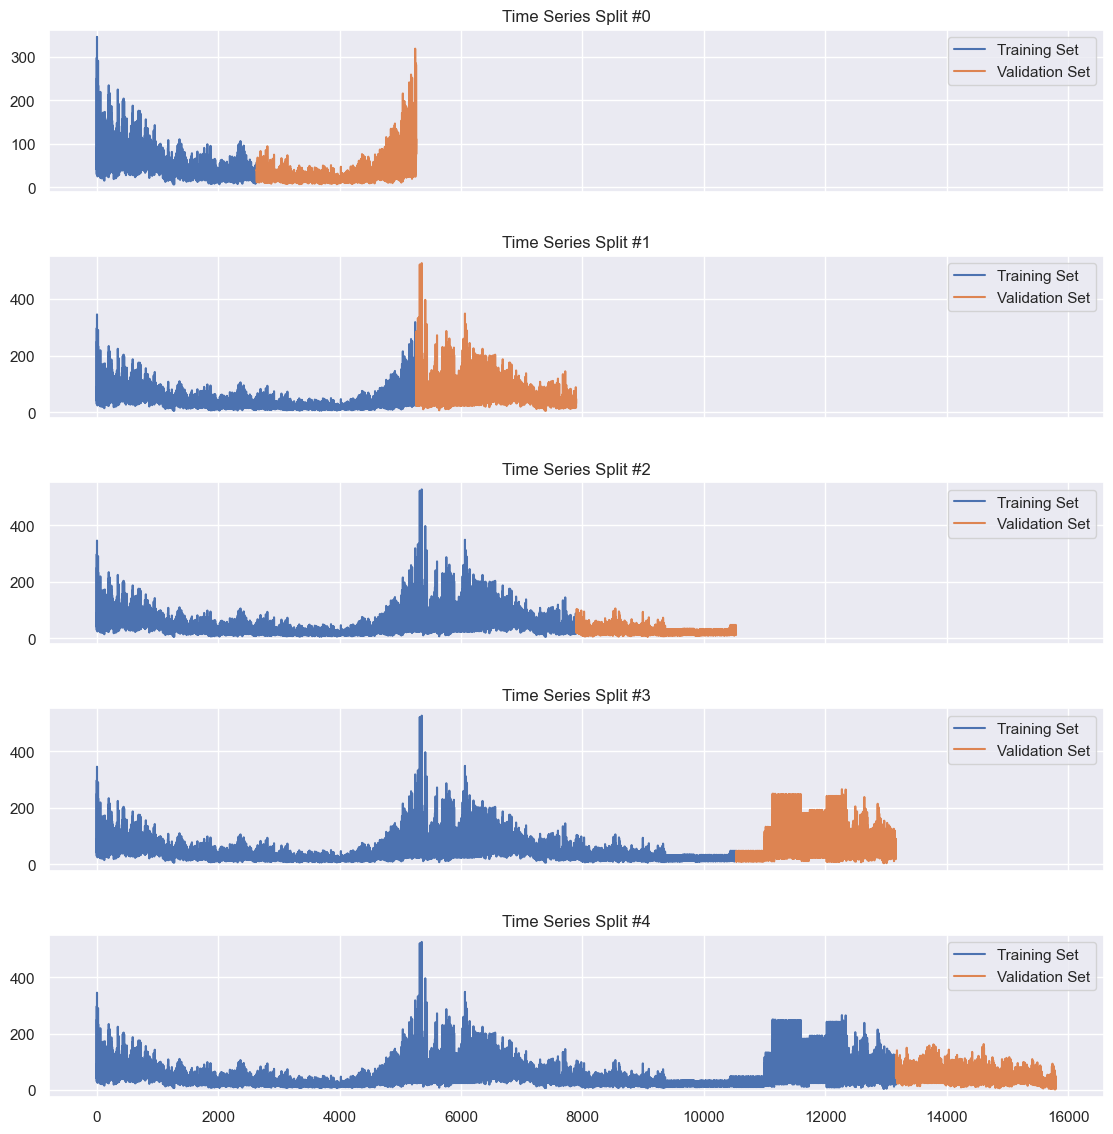

In [19]:
fig, axes = plt.subplots(tscv.n_splits, 1, figsize=(12, 12), sharex=True)
fig.tight_layout(pad=3.0)

for index, (train_fold, validation_fold) in enumerate(tscv.split(y_train)):
    sns.lineplot(data=y_train.iloc[train_fold], label='Training Set', ax=axes[index])
    sns.lineplot(data=y_train.iloc[validation_fold], label='Validation Set', ax=axes[index])
    axes[index].set_title(f'Time Series Split #{index}')
    axes[index].set(xlabel=None, ylabel=None)

plt.show()

In [20]:
alphas = np.logspace(-3, 1, num=5)
grid = {"regr__alpha": alphas}
gs = GridSearchCV(model, grid, cv=tscv, n_jobs=N_JOBS)

In [21]:
%time gs.fit(X_train, y_train);
print()

CPU times: total: 516 ms
Wall time: 13.2 s



In [22]:
get_estimator_scores("lasso_reg", gs.best_estimator_)

In [23]:
results = pd.DataFrame(gs.cv_results_)[["param_regr__alpha", "mean_test_score"]]

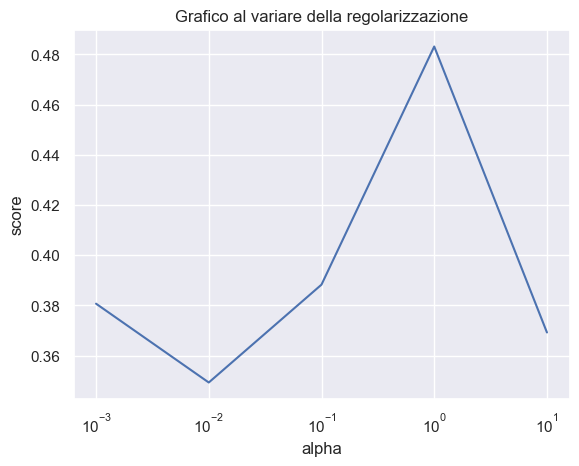

In [24]:
plt.plot(results["param_regr__alpha"], results["mean_test_score"])
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('score')
plt.title('Grafico al variare della regolarizzazione')
plt.show()

## Regressione Ridge
Proviamo la regolarizzazione con feature polinomiali per ridurre un eventuale overfitting.

In [25]:
model = Pipeline([
    ("preproc", preprocessor),
    ("poly",   PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
    ("regr", Ridge(alpha=1, max_iter=10000))
])

In [26]:
%time model.fit(X_train, y_train)

CPU times: total: 1.23 s
Wall time: 425 ms


,steps,"[('preproc', ...), ('poly', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric', ...), ('categorical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [27]:
alphas = np.logspace(-2, 8, num=12)
grid = {"regr__alpha": alphas}
gs = GridSearchCV(model, grid, cv=tscv, n_jobs=N_JOBS)

In [28]:
%time gs.fit(X_train, y_train)
print()

CPU times: total: 1.31 s
Wall time: 3.59 s



In [29]:
get_estimator_scores("ridge_reg", gs.best_estimator_)

In [30]:
results = pd.DataFrame(gs.cv_results_)[["param_regr__alpha", "mean_test_score"]]

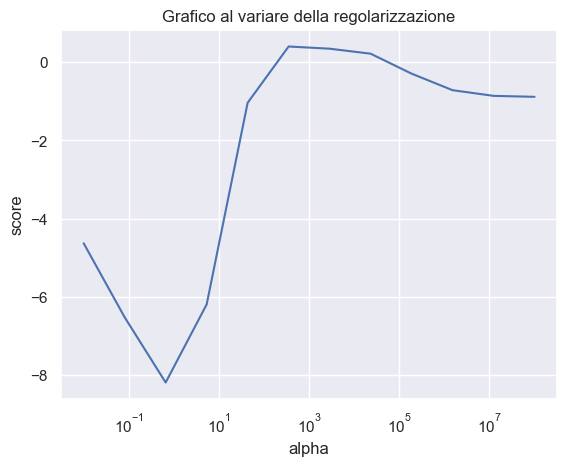

In [31]:
plt.plot(results["param_regr__alpha"], results["mean_test_score"])
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('score')
plt.title('Grafico al variare della regolarizzazione')
plt.show()

## Regressione Elastic Net
Questa regressione unisce la regolarizzazione LASSO e la regolarizzazione Ridge.

In [32]:
model = Pipeline([
    ("preproc", preprocessor),
    ("poly",   PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
    ("regr", ElasticNet(alpha=0.2, l1_ratio=0.1))
])

In [33]:
%time model.fit(X_train, y_train)

CPU times: total: 1min 18s
Wall time: 48.6 s


,steps,"[('preproc', ...), ('poly', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric', ...), ('categorical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [34]:
grid = {
    "regr__alpha":    [0.1, 1, 10],
    "regr__l1_ratio": [0.1, 0.2, 0.3]
}
gs = GridSearchCV(model, grid, cv=tscv, n_jobs=N_JOBS)

In [35]:
%time gs.fit(X_train, y_train);
print()

CPU times: total: 1min 54s
Wall time: 1min 29s



In [36]:
get_estimator_scores("elastic_net_reg", gs.best_estimator_)

## Regressione con funzioni kernel
Per ovviare ai problemi di prestazioni dei modelli con feature polinomiali, usiamo il kernel trick per evitare di creare un numero elevato di feature aggiuntive.

## Funzioni kernel polinomiali

In [37]:
model = Pipeline([
    ("preproc", preprocessor),
    ("regr",  KernelRidge(alpha=1, kernel="poly", degree=10))
])

In [38]:
%time model.fit(X_train, y_train)
print()

CPU times: total: 1min 43s
Wall time: 29.6 s



In [39]:
grid = {
    "regr__alpha":    [0.1, 1, 10],
    "regr__degree": list(range(2,30))
}
gs = RandomizedSearchCV(model, grid, n_iter=20, cv=tscv, n_jobs=N_JOBS)

In [40]:
%time gs.fit(X_train, y_train)
print()

CPU times: total: 1min 45s
Wall time: 5min 55s



In [41]:
get_estimator_scores("kernel_poly_reg", gs.best_estimator_)

In [42]:
results = pd.DataFrame(gs.cv_results_)[[
    "param_regr__alpha",
    "param_regr__degree",
    "mean_test_score"
]]
splits = sorted(results["param_regr__alpha"].unique())

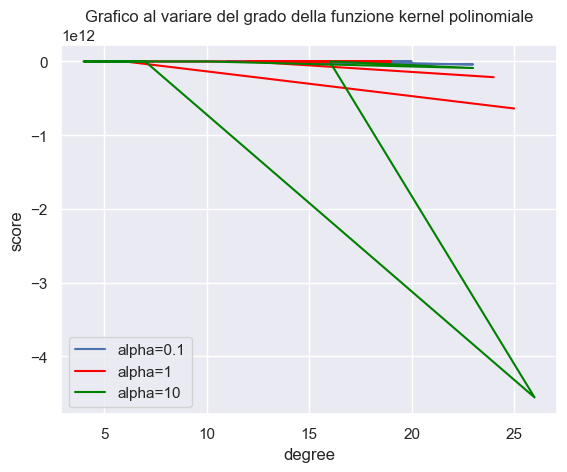

In [43]:
for split in splits:
    subset = results[results["param_regr__alpha"] == split]
    subset = subset.sort_values("param_regr__degree")
    plt.plot(
        subset["param_regr__degree"],
        subset["mean_test_score"],
        label=f"param_regr__alpha={split}"
    )

plt.xlabel('degree')
plt.ylabel('score')
plt.title("Performance al variare del grado della funzione")
plt.legend()
plt.show()

## Funzioni kernel gaussiane

Testiamo anche funzioni kernel diverse, ad esempio RBF (_radial basis function_). <br>
La funzione RBF ha la forma di una gaussiana.

In [44]:
model = Pipeline([
    ("preproc", preprocessor),
    ("regr",  KernelRidge(alpha=1, kernel="rbf", gamma=0.01))
])

In [45]:
%time model.fit(X_train, y_train)
print()

CPU times: total: 1min 39s
Wall time: 25.5 s



In [46]:
grid = {
    "regr__alpha":    [0.1, 1, 10],
    "regr__gamma": [0.01, 0.1, 1]
}
gs = GridSearchCV(model, grid, cv=tscv, n_jobs=N_JOBS)

In [47]:
%time gs.fit(X_train, y_train)
print()

CPU times: total: 1min 41s
Wall time: 3min 2s



In [48]:
get_estimator_scores("kernel_rbf_reg", gs.best_estimator_)

## Alberi decisionali

In [49]:
model = Pipeline([
    ("preproc", preprocessor),
    ("tree", DecisionTreeRegressor(max_depth=4, random_state=42))
])

In [50]:
%time model.fit(X_train, y_train)
print()

CPU times: total: 219 ms
Wall time: 253 ms



In [51]:
grid = {
    "tree__max_depth": list(range(4,30)),
    "tree__min_samples_split": [0.005, 0.01, 0.1, 0.15],
}
gs = RandomizedSearchCV(model, grid, n_iter=24, cv=tscv, n_jobs=N_JOBS)

In [52]:
%time gs.fit(X_train, y_train)
print()

CPU times: total: 703 ms
Wall time: 3.3 s



In [53]:
get_estimator_scores("decision_tree_reg", gs.best_estimator_)

In [54]:
results = pd.DataFrame(gs.cv_results_)[[
    "param_tree__min_samples_split",
    "param_tree__max_depth",
    "mean_test_score"
]]
splits = sorted(results["param_tree__min_samples_split"].unique())

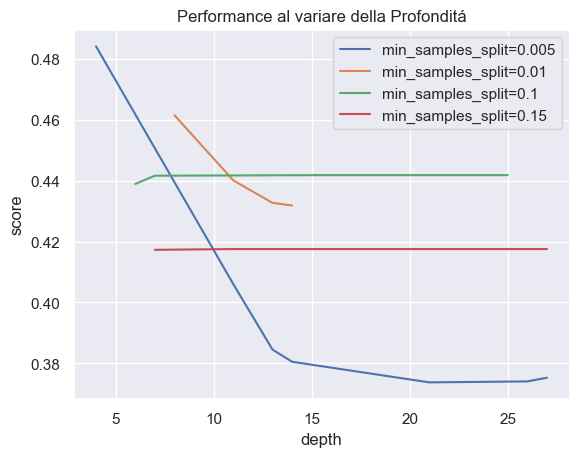

In [55]:
for split in splits:
    subset = results[results["param_tree__min_samples_split"] == split]
    subset = subset.sort_values("param_tree__max_depth")
    plt.plot(
        subset["param_tree__max_depth"],
        subset["mean_test_score"],
        label=f"min_samples_split={split}"
    )

plt.xlabel('depth')
plt.ylabel('score')
plt.title("Performance al variare della Profonditá")
plt.legend()
plt.show()

## Random forest

In [56]:
model = Pipeline([
    ("preproc", preprocessor),
    ("tree", RandomForestRegressor(max_samples=0.2, max_features="sqrt", n_estimators=200, max_depth=None, n_jobs=-1))
])

In [57]:
%time model.fit(X_train, y_train)
print()

CPU times: total: 6.62 s
Wall time: 1.09 s



Possiamo ricavare le 10 feature più importanti per la Random Forest, ovvero le variabili che sono state più utilizzate nella creazione degli alberi decisionali.

In [58]:
pd.Series(model.named_steps["tree"].feature_importances_, preprocessor.get_feature_names_out(X_train.columns)).sort_values(ascending=False).head(10)

numeric__pm_lag_1W     0.215912
numeric__pm_lag_1Y     0.130153
numeric__pm_lag_2Y     0.093482
numeric__pm_lag_1M     0.084650
numeric__co_lag_1W     0.061547
numeric__weekofyear    0.055083
numeric__dayofyear     0.053343
numeric__co_lag_1Y     0.037217
numeric__co_lag_1M     0.034153
numeric__co_lag_2Y     0.030438
dtype: float64

In [59]:
grid = {
    "tree__n_estimators": [150, 200, 250, 300],
    "tree__max_samples": [0.5, 0.6, 0.8, 1.0],
}
gs = GridSearchCV(model, grid, cv=tscv, n_jobs=N_JOBS)

In [60]:
%time gs.fit(X_train, y_train)
print()

CPU times: total: 59.2 s
Wall time: 1min 31s



In [61]:
get_estimator_scores("random_forest_reg", gs.best_estimator_)

In [62]:
results = pd.DataFrame(gs.cv_results_)[[
    "param_tree__n_estimators",
    "param_tree__max_samples",
    "mean_test_score"
]]
splits = sorted(results["param_tree__max_samples"].unique())

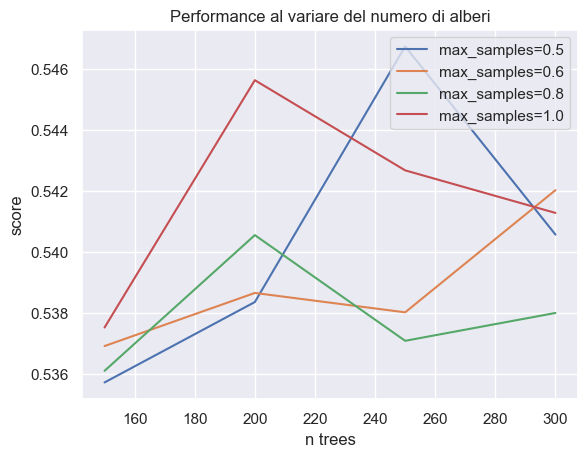

In [63]:
for split in splits:
    subset = results[results["param_tree__max_samples"] == split]
    subset = subset.sort_values("param_tree__max_samples")
    plt.plot(
        subset["param_tree__n_estimators"],
        subset["mean_test_score"],
        label=f"max_samples={split}"
    )

plt.xlabel('n trees')
plt.ylabel('score')
plt.title("Performance al variare del numero di alberi")
plt.legend()
plt.show()

## XGBoost
XGBoost crea una foresta di alberi in cui ogni albero utilizza gli errori commessi dall'albero precedente.

In [64]:
model = Pipeline([
    ("preproc", preprocessor),
    ("xgb", XGBRegressor(objective='reg:squarederror', n_estimators=200))
])

In [65]:
%time model.fit(X_train, y_train)
print()

CPU times: total: 5.12 s
Wall time: 727 ms



Possiamo ricavare le 5 feature più importanti per XGBoost, ovvero le variabili che sono state più utilizzate nella creazione degli alberi decisionali.

In [66]:
pd.Series(model.named_steps["xgb"].feature_importances_, preprocessor.get_feature_names_out(X_train.columns)).sort_values(ascending=False).head(5)

numeric__pm_lag_1W                  0.390422
categorical__state_Delhi            0.065693
numeric__weekofyear                 0.059039
categorical__state_Uttar Pradesh    0.033390
numeric__dayofyear                  0.030644
dtype: float32

In [67]:
grid = {
    "xgb__max_depth": [3, 5, 7, 10],
    "xgb__n_estimators": [100, 200, 400, 700, 1000],
}
gs = GridSearchCV(model, grid, cv=tscv, n_jobs=N_JOBS)

In [68]:
%time gs.fit(X_train, y_train)
print()

CPU times: total: 28.3 s
Wall time: 50 s



In [69]:
get_estimator_scores("xgboost_reg", gs.best_estimator_)

In [70]:
results = pd.DataFrame(gs.cv_results_)[["param_xgb__max_depth","param_xgb__n_estimators","mean_test_score"]]
results_3 = results[results["param_xgb__max_depth"] == 3]
results_5 = results[results["param_xgb__max_depth"] == 5]
results_7 = results[results["param_xgb__max_depth"] == 7]
results_10 = results[results["param_xgb__max_depth"] == 10]

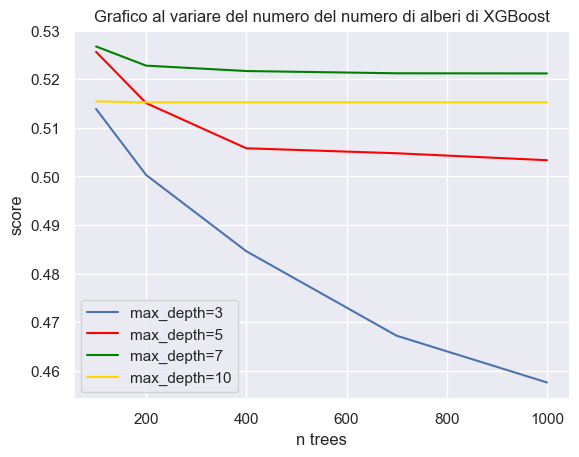

In [71]:
plt.plot(results_3["param_xgb__n_estimators"], results_3["mean_test_score"])
plt.plot(results_5["param_xgb__n_estimators"], results_5["mean_test_score"], c="red")
plt.plot(results_7["param_xgb__n_estimators"], results_7["mean_test_score"], c="green")
plt.plot(results_10["param_xgb__n_estimators"], results_10["mean_test_score"], c="gold")
plt.xlabel('n trees')
plt.ylabel('score')
plt.legend(["max_depth=3","max_depth=5","max_depth=7","max_depth=10"])
plt.title('Grafico al variare del numero del numero di alberi di XGBoost')
plt.show()

## MLP
La classe `MLP` definisce una rete neurale feed-forward a più strati completamente connessi, con:

- Numero di neuroni personalizzabile per ogni layer nascosto (`hidden_sizes`);
- Funzione di attivazione ReLU dopo ogni layer lineare;
- Dropout applicato dopo ogni attivazione per ridurre l'overfitting;
- Uno strato di output lineare con un singolo neurone per la regressione.


In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device utilizzato: {device}")

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_sizes, dropout):
        super().__init__()
        layers = []
        dim = input_dim
        for hs in hidden_sizes:
            layers.append(nn.Linear(dim, hs))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            dim = hs
        layers.append(nn.Linear(dim, 1))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

Device utilizzato: cpu


### Implementazione dell’Early Stopping

La classe `EarlyStopper` consente di interrompere anticipatamente l'addestramento se la loss di validazione non migliora dopo un numero definito di epoche (`patience`). Velocizza l'ottimizzazione e riduce overfitting.

In [73]:
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')

    def early_stop(self, val_loss):
        # Se la loss migliora (di almeno min_delta), resettiamo il counter
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            # Se la loss non migliora da 'patience' epoche, dobbiamo fermarci
            if self.counter >= self.patience:
                return True
        return False

### Funzioni per il training e la valutazione

- `train_epoch`: esegue un'epoca di addestramento, aggiornando i pesi tramite backpropagation e accumulando la loss media ponderata.

- `eval_loss`: calcola la loss media sul set di validazione, senza aggiornare i pesi (modalità evaluation).

In [74]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(Xb), yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * Xb.size(0)
    return total_loss / len(loader.dataset)

def eval_loss(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)
            total_loss += criterion(model(Xb), yb).item() * Xb.size(0)
    return total_loss / len(loader.dataset)

### Random Search con Cross-Validation temporale e Early Stopping

La funzione `random_search` esegue una ricerca casuale di iperparametri sullo spazio definito, valutando ogni configurazione tramite `TimeSeriesSplit` per rispettare la dipendenza temporale dei dati.

Per ogni combinazione di iperparametri:

- Viene addestrato un modello MLP su ciascun fold del training set;
- Viene monitorata la loss di validazione con Early Stopping per fermare l’addestramento se non ci sono miglioramenti;
- Alla fine si calcola la media delle loss di validazione su tutti i fold.

Il modello con la miglior media di loss viene restituito insieme ai relativi iperparametri.

In [75]:
def random_search(model_builder, param_dist, dataset,
                           n_iter=10, holdout_split=0.2,
                           early_patience=5,
                           early_min_delta=1e-4):
    """
    Performs hyperparameter tuning using holdout validation, respecting data order.

    Args:
        model_builder (function): A function that returns a new, un-trained model instance.
        param_dist (dict): The dictionary of hyperparameters to sample from.
        dataset (torch.utils.data.Dataset): The entire dataset.
        n_iter (int): The number of hyperparameter combinations to test.
        holdout_split (float): The proportion of the dataset to use for validation (e.g., 0.2 for 20%).
        early_patience (int): How many epochs to wait for improvement before stopping.
        early_min_delta (float): The minimum change in validation loss to be considered an improvement.
    """
    train_keys = ['lr', 'batch_size', 'max_epochs']
    best_val_loss = float('inf')
    best_model_params, best_train_params = None, None
    best_model = None

    # --- Create a single, time-aware train/validation split ---
    # The validation set is the last 'holdout_split' proportion of the data.
    split_index = int(len(dataset) * (1 - holdout_split))
    train_subset = Subset(dataset, range(split_index))
    val_subset = Subset(dataset, range(split_index, len(dataset)))

    print("Avvio Random Search con Holdout Validation...")
    print(f"Dimensioni set di addestramento: {len(train_subset)}")
    print(f"Dimensioni set di validazione:  {len(val_subset)}")
    print("-" * 40)

    # Sampler for hyperparameters
    param_sampler = ParameterSampler(param_dist, n_iter=n_iter, random_state=RANDOM_STATE)

    for param_id, params in enumerate(param_sampler):
        print(f"Test Parametri {param_id+1}/{n_iter}: {params}")

        # Separate model and training parameters
        model_params = {k: v for k, v in params.items() if k not in train_keys}
        train_params = {k: v for k, v in params.items() if k in train_keys}

        # Create DataLoaders
        train_loader = DataLoader(train_subset, batch_size=train_params['batch_size'], shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=train_params['batch_size'], shuffle=False)

        # Initialize model, optimizer, and early stopper for this run
        model = model_builder(**model_params).to(device)
        optimizer = optim.Adam(model.parameters(), lr=train_params['lr'])
        stopper = EarlyStopper(patience=early_patience, min_delta=early_min_delta)
        criterion = nn.MSELoss() # Or your preferred loss function

        # --- Training Loop ---
        for epoch in range(train_params['max_epochs']):
            train_epoch(model, train_loader, optimizer, criterion)
            val_loss = eval_loss(model, val_loader, criterion)

            if epoch % 10 == 0:
                print(f"    Epoch {epoch}: val_loss = {val_loss:.6f}")

            if stopper.early_stop(val_loss):
                print(f"    Early stopping at epoch {epoch}.")
                break
        
        # Get the final validation loss after training is complete
        final_val_loss = eval_loss(model, val_loader, criterion)
        print(f"  -> Loss di validazione finale: {final_val_loss:.6f}")

        # --- Check for Best Model ---
        if final_val_loss < best_val_loss:
            best_val_loss = final_val_loss
            best_model_params = model_params
            best_train_params = train_params
            best_model = model # Save the best model object
            print(f"  ==> Nuova migliore loss di validazione: {best_val_loss:.6f}")
        print("-" * 40)

    print("\nRicerca completata.")
    print(f"Migliore loss di validazione: {best_val_loss:.6f}")
    print(f"Migliori parametri del modello: {best_model_params}")
    print(f"Migliori parametri di addestramento: {best_train_params}")

    return best_model, best_model_params, best_train_params

### Preparazione dati e spazio di ricerca iperparametri

- I dati di training vengono trasformati tramite il preprocessore definito;
- Viene creato un dataset PyTorch completo (features + target);
- Definiamo gli intervalli di ricerca per gli iperparametri chiave del modello MLP:

  - Dimensioni degli hidden layer (`hidden_sizes`);
  - Dropout rate (`dropout`);
  - Learning rate (`lr`);
  - Batch size (`batch_size`);
  - Numero massimo di epoche (`max_epochs`).

In [76]:
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

X_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
y_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)

full_dataset = TensorDataset(X_tensor, y_tensor)

input_dim = X_tensor.shape[1]
mlp_param_dist = {
    'input_dim': [input_dim],
    'hidden_sizes': [(32,32), (64,64), (128,)],
    'dropout': [0.0, 0.2, 0.5],
    'lr': [1e-3, 1e-4],
    'batch_size': [32, 64],
    'max_epochs': [50, 100]
}

### Avvio della ricerca e valutazione

- Eseguiamo la random search passando il costruttore del modello, lo spazio di iperparametri e il dataset;
- Una volta ottenuto il miglior modello, valutiamo le sue prestazioni sul test set.

In [77]:
best_model, model_params, train_params = random_search(
    lambda **p: MLP(**p), mlp_param_dist, full_dataset
)

X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1).to(device)

get_torch_estimator_scores("MLP", best_model,
                           X_tensor.to(device), y_tensor.to(device),
                           X_test_tensor, y_test_tensor,
                           device)

Avvio Random Search con Holdout Validation...
Dimensioni set di addestramento: 12634
Dimensioni set di validazione:  3159
----------------------------------------
Test Parametri 1/10: {'max_epochs': 50, 'lr': 0.001, 'input_dim': 40, 'hidden_sizes': (64, 64), 'dropout': 0.0, 'batch_size': 32}
    Epoch 0: val_loss = 535.263745
    Early stopping at epoch 7.
  -> Loss di validazione finale: 436.402524
  ==> Nuova migliore loss di validazione: 436.402524
----------------------------------------
Test Parametri 2/10: {'max_epochs': 50, 'lr': 0.0001, 'input_dim': 40, 'hidden_sizes': (32, 32), 'dropout': 0.5, 'batch_size': 64}
    Epoch 0: val_loss = 3419.518017
    Epoch 10: val_loss = 1187.605383
    Epoch 20: val_loss = 780.918903
    Epoch 30: val_loss = 607.059434
    Epoch 40: val_loss = 513.032795
  -> Loss di validazione finale: 461.150412
----------------------------------------
Test Parametri 3/10: {'max_epochs': 50, 'lr': 0.0001, 'input_dim': 40, 'hidden_sizes': (64, 64), 'dropout'

# Confronto Visivo delle Prestazioni dei Modelli

La funzione `plot_estimator_scores(scores)` consente di visualizzare in modo sintetico ed intuitivo le metriche di valutazione di tutti i modelli allenati. I grafici generati permettono un confronto diretto tra le prestazioni su diverse metriche chiave:

- **R² Score**: confronta le prestazioni sul training set e sul test set per identificare possibili fenomeni di overfitting.
- **MSE (Mean Squared Error)**: evidenzia la media degli errori quadratici di previsione; penalizza fortemente gli outlier elevando al quadrato ogni errore.
- **MAE (Mean Absolute Error)**: mostra la media dell’errore assoluto commesso da ciascun modello.
- **MAPE (Mean Absolute Percentage Error)**: fornisce un’indicazione dell’errore medio in termini percentuali rispetto ai valori reali.
- **Max Error**: evidenzia il peggior errore assoluto commesso su un’osservazione.
- **Intervalli di Confidenza (CI95%)**: per le metriche **MSE**, **MAE** e **MAPE** viene stimato un intervallo di confidenza al 95% tramite bootstrap resampling, al fine di rappresentare l'incertezza statistica associata a ciascuna metrica.

Questa visualizzazione finale è utile per trarre conclusioni sulla bontà predittiva di ciascun modello e guidare la scelta del miglior approccio da adottare.

In [78]:
def plot_estimator_scores(scores):
    melted_r2_adj = (
        scores[['model', 'r2_train_adj', 'r2_test_adj']]
        .rename(columns={'r2_train_adj':'train','r2_test_adj':'test'})
        .melt(id_vars='model', var_name='set', value_name='score')
    )

    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    fig.tight_layout(pad=4)

    axs[0, 0].set_title('R² Aggiustato')
    sns.barplot(data=melted_r2_adj, x='score', y='model', hue='set', ax=axs[0, 0])
    axs[0, 0].legend(loc='lower right')

    axs[0, 1].set_title('MSE ± CI95%')
    for _, row in scores.iterrows():
        axs[0, 1].barh(
            row['model'], row['mse'],
            xerr=[[row['mse']-row['mse_low']], [row['mse_high']-row['mse']]],
            capsize=5
        )
    axs[0, 1].invert_yaxis()

    axs[0, 2].set_title('MAE ± CI95%')
    for _, row in scores.iterrows():
        axs[0, 2].barh(
            row['model'], row['mae'],
            xerr=[[row['mae']-row['mae_low']], [row['mae_high']-row['mae']]],
            capsize=5
        )
    axs[0, 2].invert_yaxis()

    axs[1, 0].set_title('MAPE ± CI95%')
    for _, row in scores.iterrows():
        axs[1, 0].barh(
            row['model'], row['mape'],
            xerr=[[row['mape']-row['mape_low']], [row['mape_high']-row['mape']]],
            capsize=5
        )
    axs[1, 0].invert_yaxis()

    axs[1, 1].set_title('Max Error')
    for _, row in scores.iterrows():
        axs[1, 1].barh(row['model'], row['max_error'])
    axs[1, 1].invert_yaxis()

    axs[1, 2].axis('off')

    plt.show()

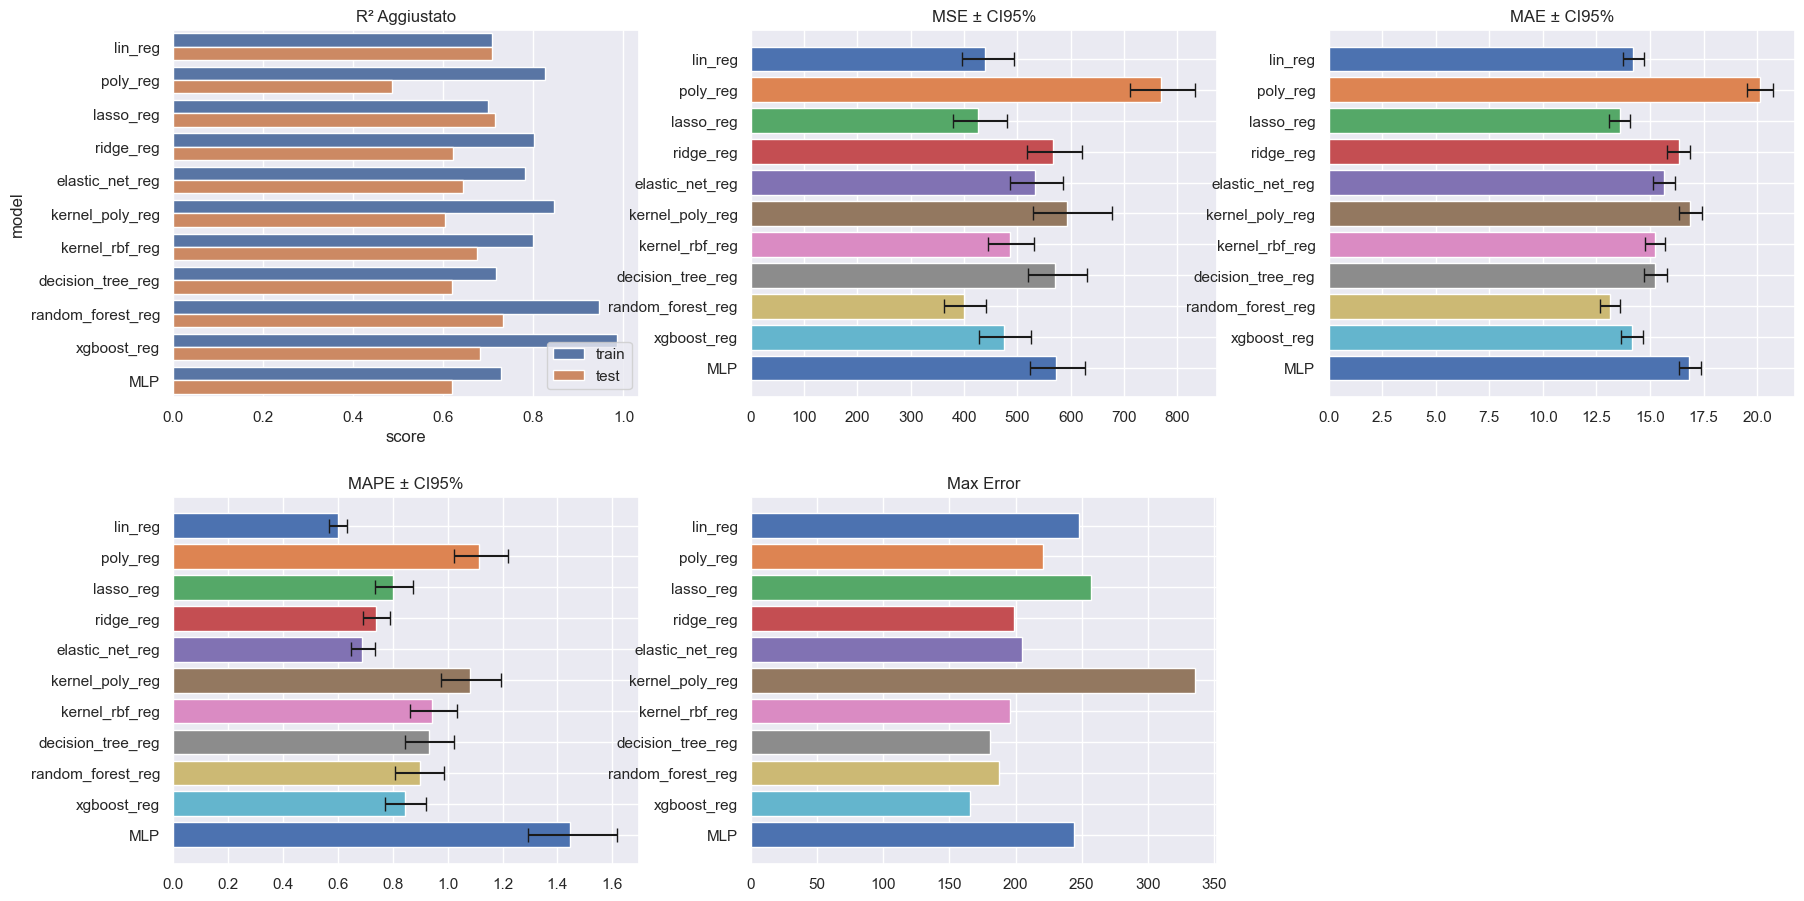

In [79]:
estimator_scores_df = pd.DataFrame(
    all_scores,
    columns = [
        'model',
        'r2_train_adj', 'r2_test_adj',
        'mse', 'mse_low', 'mse_high',
        'mae', 'mae_low', 'mae_high',
        'mape', 'mape_low', 'mape_high',
        'max_error'
    ]
)
plot_estimator_scores(estimator_scores_df)

# Selezione del Miglior Modello
Calcoliamo un punteggio complessivo per ciascun modello basandoci sulle metriche di valutazione.

In [80]:
# 1) Scegliamo le metriche da includere nel ranking:
metrics = {
    'r2_test_adj': 'max',
    'mse': 'min',
    'mae': 'min',
    'mape': 'min',
    'max_error': 'min'
}

# 2) Costruzione DataFrame dei rank
df = estimator_scores_df.set_index('model')
ranks = pd.DataFrame(index=df.index)
for metric, direction in metrics.items():
    ranks[f"{metric}_rank"] = df[metric].rank(ascending=(direction=='min'))

# 3) Calcolo punteggio complessivo: somma dei rank normalizzati
ranks['total_rank'] = ranks.sum(axis=1)

# 4) Selezione del miglior modello
best_model = ranks['total_rank'].idxmin()
best_score = ranks['total_rank'].min()

# Output dei risultati
print("Ranking modelli:")
ranks.sort_values('total_rank')

Ranking modelli:


,r2_test_adj_rank,mse_rank,mae_rank,mape_rank,max_error_rank,total_rank
model,,,,,,
random_forest_reg,1.0,1.0,1.0,6.0,3.0,12.0
xgboost_reg,4.0,4.0,3.0,5.0,1.0,17.0
lin_reg,3.0,3.0,4.0,1.0,9.0,20.0
lasso_reg,2.0,2.0,2.0,4.0,10.0,20.0
elastic_net_reg,6.0,6.0,7.0,2.0,6.0,27.0
kernel_rbf_reg,5.0,5.0,5.0,8.0,4.0,27.0
ridge_reg,7.0,7.0,8.0,3.0,5.0,30.0
decision_tree_reg,9.0,8.0,6.0,7.0,2.0,32.0
MLP,8.0,9.0,9.0,11.0,8.0,45.0


In [81]:
print(f"\nMiglior modello: {best_model} (punteggio complessivo = {best_score})")


Miglior modello: random_forest_reg (punteggio complessivo = 12.0)
